In [42]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import skimage

# Define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, middle_layer_size=30):  # Set the desired size for the middle layer
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )

        self.middle = nn.Sequential(
            nn.Linear(8*7*7, 50),  # Adjust the input size based on the output size of the encoder
            nn.ReLU(),
            nn.Linear(50, middle_layer_size),  # Set the desired size for the middle layer
            nn.ReLU(),
            nn.Linear(middle_layer_size, 50),  # Set the desired size for the middle layer
            nn.ReLU(),
            nn.Linear(50, 8*7*7),  # Adjust the output size based on the input size of the decoder
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print(f"1: {x.size()}")
        x = self.encoder(x)
        # print(f"2: {x.size()}")
        x = x.view(x.size(0), -1)  # Flatten the output before passing it to the fully connected layers
        # print(f"3: {x.size()}")
        x = self.middle(x)
        # print(f"4: {x.size()}")
        x = x.view(x.size(0), 8, 7, 7)  # Reshape before passing it to the decoder
        # print(f"5: {x.size()}")
        x = self.decoder(x)
        # print(f"6: {x.size()}")
        return x

# Function to add noise to images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, 0.0, 1.0)

# Function to train the autoencoder
def train_autoencoder(model, dataloader, val_data, test_data, num_epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for data in dataloader:
            images, _ = data
            noisy_images = add_noise(images)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            # outputs = torch.tensor(outputs)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to visualize results
def visualize_results(model, dataloader):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, _ = data
            noisy_images = add_noise(images)

            outputs = model(noisy_images)

            plt.figure(figsize=(15, 5))
            for i in range(5):
                plt.subplot(2, 5, i + 1)
                plt.imshow(np.squeeze(noisy_images[i]), cmap='gray')
                plt.title('Noisy Image')
                plt.subplot(2, 5, i + 6)
                plt.imshow(np.squeeze(outputs[i]), cmap='gray')
                plt.title('Denoised Image')
            plt.show()
            break  # Display only the first batch



Epoch [1/5], Loss: 0.0652
Epoch [2/5], Loss: 0.0618
Epoch [3/5], Loss: 0.0522
Epoch [4/5], Loss: 0.0443
Epoch [5/5], Loss: 0.0379


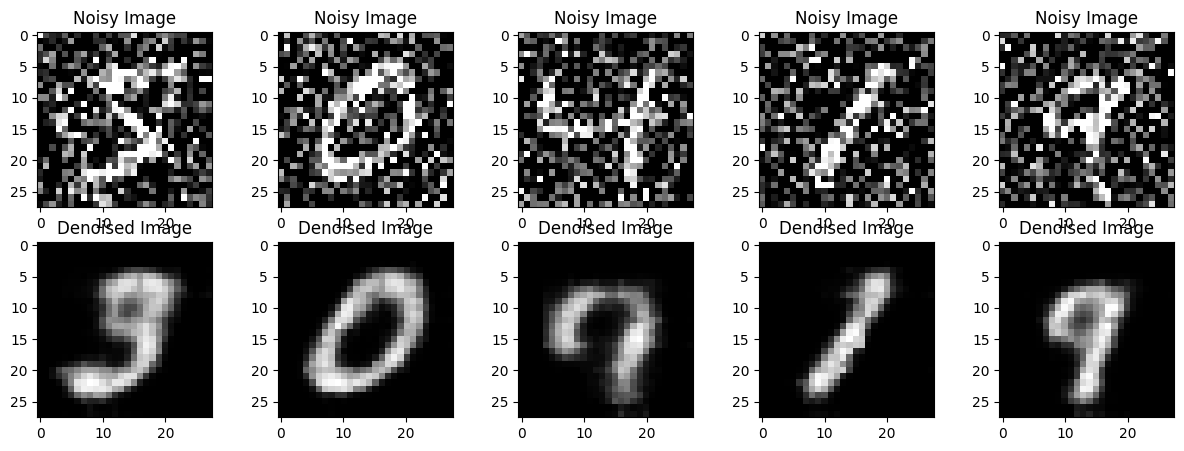

In [45]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# Create an instance of the Autoencoder
autoencoder = Autoencoder(middle_layer_size=16)  # Set the desired size for the middle layer

# Train the Autoencoder
train_autoencoder(autoencoder, train_dataloader, num_epochs=5)

# Visualize results
visualize_results(autoencoder, train_dataloader)